# Engineering a training dataset
In this notebook we will create a dataset to train a regression model, and guess customer engagement with an uploaded recipe
We will follow our planning created from the first exploration of the data:


![table](../images/table-planning.jpg)


# We start shaping the MVP data


In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

start using RAW_interactions to score the interactions per recipes. 

In [2]:
interactions = pd.read_csv("../data/RAW_interactions.csv")
interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [3]:
interactions.rename(columns = {'date':'interaction_date','recipe_id':'id'}, inplace = True)

In [4]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   user_id           1132367 non-null  int64 
 1   id                1132367 non-null  int64 
 2   interaction_date  1132367 non-null  object
 3   rating            1132367 non-null  int64 
 4   review            1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


we need to use pandas_groupby to start calculating aggregations

In [5]:
recipes = pd.read_csv("../data/RAW_recipes.csv")
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


As the database covers up to end of 2018 interactions, we will use 2018-12-31 as the reference day, as if we were doing this analysis then. 

In [6]:
REF_DAY = '2018-12-31'

Now I want to bring over the subitted day of each recipe into the interaction dataset. 

In [7]:
submission_table = recipes[['id','submitted','contributor_id']]
submission_table.head()

,id,submitted,contributor_id
0,137739,2005-09-16,47892
1,31490,2002-06-17,26278
2,112140,2005-02-25,196586
3,59389,2003-04-14,68585
4,44061,2002-10-25,41706


In [8]:
interactions = interactions.merge(submission_table, on='id')
interactions.head()

,user_id,id,interaction_date,rating,review,submitted,contributor_id
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,2002-09-21,1533
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",2002-09-21,1533
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,2002-10-27,56824
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,2004-02-25,64342
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",2004-02-25,64342


In [9]:
interactions['interaction_date'] = pd.to_datetime(interactions['interaction_date'])
interactions['submitted'] = pd.to_datetime(interactions['submitted'])

In [10]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1132367 non-null  int64         
 1   id                1132367 non-null  int64         
 2   interaction_date  1132367 non-null  datetime64[ns]
 3   rating            1132367 non-null  int64         
 4   review            1132198 non-null  object        
 5   submitted         1132367 non-null  datetime64[ns]
 6   contributor_id    1132367 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(1)
memory usage: 69.1+ MB


In [11]:
interactions['days_after_recipe_submission'] = [d.days for d in (interactions['interaction_date']-interactions['submitted'])]

In [12]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 8 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   user_id                       1132367 non-null  int64         
 1   id                            1132367 non-null  int64         
 2   interaction_date              1132367 non-null  datetime64[ns]
 3   rating                        1132367 non-null  int64         
 4   review                        1132198 non-null  object        
 5   submitted                     1132367 non-null  datetime64[ns]
 6   contributor_id                1132367 non-null  int64         
 7   days_after_recipe_submission  1132367 non-null  int64         
dtypes: datetime64[ns](2), int64(5), object(1)
memory usage: 77.8+ MB


In [13]:
interactions.head()

,user_id,id,interaction_date,rating,review,submitted,contributor_id,days_after_recipe_submission
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,2002-09-21,1533,149
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",2002-09-21,1533,3378
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,2002-10-27,56824,35
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,2004-02-25,64342,2194
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",2004-02-25,64342,2775


We will do the sentiment analysis now before calculating these aggregations 

In [14]:
from textblob import TextBlob

In [15]:
pol = lambda x: TextBlob(x).polarity

In [16]:
interactions['review_pol'] = [pol(str(rev)) for rev in interactions['review']]

In [17]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 9 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   user_id                       1132367 non-null  int64         
 1   id                            1132367 non-null  int64         
 2   interaction_date              1132367 non-null  datetime64[ns]
 3   rating                        1132367 non-null  int64         
 4   review                        1132198 non-null  object        
 5   submitted                     1132367 non-null  datetime64[ns]
 6   contributor_id                1132367 non-null  int64         
 7   days_after_recipe_submission  1132367 non-null  int64         
 8   review_pol                    1132367 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(5), object(1)
memory usage: 86.4+ MB


<AxesSubplot:>

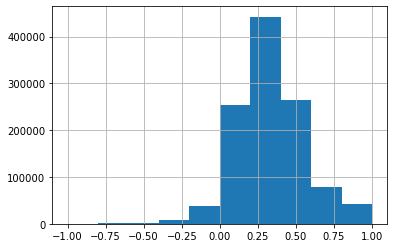

In [18]:
interactions.review_pol.hist()

In [19]:
interactions = interactions[['id',
                             'user_id',
                             'review',
                             'rating',
                             'interaction_date',
                             'submitted',
                             'contributor_id'
                             'days_after_recipe_submission',
                             'review_pol']]
interactions.head()

,id,user_id,review,rating,interaction_date,submitted,days_after_recipe_submission,review_pol
0,40893,38094,Great with a salad. Cooked on top of stove for...,4,2003-02-17,2002-09-21,149,0.270000
1,40893,1293707,"So simple, so delicious! Great for chilly fall...",5,2011-12-21,2002-09-21,3378,0.242857
2,44394,8937,This worked very well and is EASY. I used not...,4,2002-12-01,2002-10-27,35,0.366667
3,85009,126440,I made the Mexican topping and took it to bunk...,5,2010-02-27,2004-02-25,2194,0.350000
4,85009,57222,"Made the cheddar bacon topping, adding a sprin...",5,2011-10-01,2004-02-25,2775,-0.208333


Save in a clean dataframe to be used later in tableau for more exploratory analysis

In [20]:
interactions.to_csv("../data/clean-data/interactions_clean.csv")

Now we calculate aggregations in order to enrich the recipe dataframe